<a href="https://colab.research.google.com/github/alicesquivel/powder/blob/main/interference_loc_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Localization of a signal source using cross correlation and TDOA

Authors: 

> Chia Ying Kuo, Aarti Singh, and Neal Patwari
>
> Washington University in St. Louis
>
> version 1.1, January 2023

### Introduction

This jupyter notebook provides code to locate a signal source from recorded received samples at multiple synchronized receivers.  The code cross-correlates each pair of received signals.  One peak from each receiver pair's cross-correlation is used, which corresponds to a time difference of arrival (TDOA) measurement.  These TDOA measurements from every pair are then used to estimate the source location, using minimum mean-squared error (MMSE) localization. 

The code is left as a notebook because it is important that the user carefully observe the cross-correlation, TDOA measurements, and then the root mean squared error (RMSE).  Sometimes a pairwise measurement is invalid, perhaps because no signal was measured at one of the receivers, or because multiple sources contributed to the received signals.  In these cases, observing the intermediate outputs is needed to that it went wrong, and perhaps why.

General info about Colab from Google: 

> To execute the code in any cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.



## Setup this Python Environment

First, go to the file menu on the colab "CO" menu and `Save a Copy in Drive`.  This is because this shared doc is a read only copy.

This python notebook came from [our gitlab interference_source_localization project page](https://gitlab.flux.utah.edu/npatwari/interference_source_localization).  The following instructions assume you have all of the files from that public project, either by downloading files or cloning the repo.

We need to upload any file that colab needs, besides this .ipynb file.  In particular we need to load the data files.  Currently colab requires us to upload one file at a time.  Because we're impatient, we zipped all of the data files together, and we'll upload that one zip file, and then unzip it.

To upload the file: 
 - **Click on the folder icon** at the leftmost column of this page.  Then, you should see a `..` folder and a `sample_data` folder, and four icons above that directory listing. 
 - **Click on the Upload icon**, which looks like a piece of paper with an up arrow on it.  
 - **Select and upload** the `testdata.zip` file (or whatever your measurement zip file is called). It asks you to confirm that it will delete them when your session expires (which means you need to do it again if the session expires).  Click OK.
 - **Run the exec command below** again with the name of your zip file; and then **click the refresh icon** (it looks like a file folder with a circle-arrow on it) to make sure that the measurement folders and files are now in the directory.
 - You can hit the "X" at the top right of the File pane if you want at this point, to save window space.

In [ ]:
!unzip testdata.zip

Archive:  testdata.zip
   creating: test1/
  inflating: test1/rx_honors_raw     
  inflating: test1/rx_ustar_raw      
  inflating: test1/rx_smt_raw        
   creating: test2/
  inflating: test2/rx_honors_raw     
  inflating: test2/rx_ustar_raw      
  inflating: test2/rx_smt_raw        
   creating: test3/
  inflating: test3/rx_honors_raw     
  inflating: test3/rx_ustar_raw      
  inflating: test3/rx_smt_raw        


We need to tell colab to add packages that are not default.  The !pip command does this for the "utm" package, which we will use.

In [ ]:
!pip install utm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6108 sha256=c59be95c418650028c137968e4d8296c6620b2791d61a5b1b89cc6e7ff4b0858
  Stored in directory: /root/.cache/pip/wheels/65/e2/d8/878a8cc986641056fbfebefc4d8eb64238a7b6d3426e86b447
Successfully built utm


For the last setup step, run this to define some functions we'll be using.

In [ ]:
#!/usr/bin/python3
#Program that takes in a complex binary file (fc32) of channel impulse response

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from math import dist
from scipy import signal
import utm

########################################################
# I/O and utility functions

speed_of_light = 299792458.0 # meters per second

#Takes in complex vector and returns magnitude squared
def complexToMagS(c):
    return np.abs(c)**2

def readBin(file_path):
    return np.fromfile(file_path, dtype=np.float32)

def readCom(file_path):
    return np.fromfile(file_path, dtype=np.complex64)

########################################################
# Coordinate Handling Functions

# Generate a list of pixel coordinates in a 2D (x,y) rectangular grid.
def calcGridPixelCoords(personLL, personUR, delta_p, area_range):
    
    pixelCoords=[]
    xVals  = np.arange(personLL[0]-area_range, personUR[0]+area_range, delta_p)
    yVals  = np.arange(personLL[1]-area_range, personUR[1]+area_range, delta_p)
    cols   = len(xVals)
    pixels = cols * len(yVals)  # len(yVals) is the number of rows of pixels

    # fill the first row, then the 2nd row, etc.
    for i in range(pixels):
        xindex = i%cols
        yindex = i//cols
        pixelcoords = [xVals[xindex], yVals[yindex], 0]
        pixelCoords.append(pixelcoords)
    
    return pixelCoords, xVals, yVals

# Calculate the coordinates of a bounding box of all coordinates in the given dictionary
# input: utm, dictionary of UTM coordinates
# Output: minCoord, the lower left coordinate
# Output: maxCoord, the upper right coordinate
def minimumUtmCoord(utm):
    coordArray = np.array(list(ant_utm.values())) # put coordinates from dict into numpy array
    minCoord = np.min(coordArray, axis=0)
    maxCoord = np.max(coordArray, axis=0)
    return minCoord, maxCoord


#given 2 utm points and their heights, calculate distance
def utmDistance(p1,p2):
    distance = np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2)
    return distance

# Return the receiver pair's node names, given a receiver pair that is named "<pos_node> to <neg_node>"
def pairToNodes(pair):
    temp = pair.split()
    if len(temp) == 3:
        return temp[0], temp[2]
    else:  # Error handling
        print("pairToNodes(pair) called with a receiver pair that does not have two node names: " + pair)
        return '', ''

########################################################
# RMSE Handling Functions

# Calculate the sum of squared error for a transmitter at each pixel, given the TDOA measurements 
#.  and given antenna locations.  All coords are UTM coordinates in meters.
#.  All TDOAs are in seconds.
# Output the sum of squared error (SSE) for each pixel.
# Output the index of the minimum pixel.
def calcRMSE(pixelCoords, ant_utm, meas_TDoA, pairs_to_ignore):

    SSE = np.zeros(len(pixelCoords))
    pairs_used = 0
    # For all pairs not in the "pairs_to_ignore" list
    for pair in meas_TDoA:
        if pair not in pairs_to_ignore:
            node1, node2 = pairToNodes(pair)
            coord1 = ant_utm[node1]
            coord2 = ant_utm[node2]
            pairs_used += 1
            # For each pixel (aka possible source location)
            for i, pix in enumerate(pixelCoords):
                # The theoretical time difference is the difference in distances from the source 
                # to the two receivers, divided by the speed of light.
                theory_tdoa = (dist(coord1, pix) - dist(coord2, pix))/speed_of_light
                # The "error" is the difference between the theoretical time difference and the
                # measured time difference, both in seconds. SSE is the sum of the squared error.
                SSE[i] += (theory_tdoa - meas_TDoA[pair])**2

    i_min = np.argmin(SSE)
    # RMSE is the square root of the average ('mean') squared error. SSE is the sum of squared error.
    RMSE = np.sqrt(SSE/pairs_used)

    return RMSE, i_min


## Loading and Signal Visualization

Read data from the recorded files.  Four things the user must do here:

- **Please change the path** where the recorded files are located in `directory_str`.
- **List the nodes which were the receivers used in this experiment** in `nodes_name`.
- **Set the sampling frequency** in `Fs`.  This is a parameter from the recording scripts.
- **Set the duration of a measurement file** in `d`.  This is a parameter from the recording scripts.

In [ ]:
directory_str = './'

# Code for the old file naming strategy
directory_str = 'test3/'  # This expects a slash at the end of the string.
nodes_name = ['honors','smt','ustar'] # include the nodes name you are using
raw_data = dict()
for node in nodes_name:
    fname = directory_str + "rx_" + node + "_raw"
    print("Loaded file: " + fname)
    raw_data[node] = readCom(directory_str + "rx_" + node + "_raw")

## Copy in the host_dict from fabfile.py
#host_dict = {'hospital': "aarti@pc702.emulab.net", 'smt': "aarti@pc703.emulab.net",  'ustar': "aarti@pc704.emulab.net"}
#
## Load each data file, one from each directory.  Directories are named after the 
## computer IP address, not the location.
#nodes_name = list(host_dict.keys()) 
#raw_data = dict()
#for nodename, host in host_dict.items():
#    hostname = host.split('@')[1]    # Take the IP address, drop the user name
#    hostdirec = directory_str + hostname + '/disturb'
#    raw_data[nodename] = readCom(hostdirec)
#    print("Loaded File from: " + hostdirec, "for ", nodename)


# Recorded signal settings
Fs = 20e6 # sampling rate in samples per second
d  = 100e-3 # time duration for collection in seconds
node_n = len(nodes_name)
print("Number of nodes: " + str(node_n))

Loaded file: test3/rx_honors_raw


NameError: ignored

### Visualize the Recorded Signals

This section is to show the user the data.  You should visually inspect that it looks synchronized, and that it looks like there is one signal that all receivers are looking at.  If there are some signals that don't really capture the same signal, maybe you should rerun this script without that receiver. 

I'm not sure how to show all of the subfigures in a pleasing way when the number of receivers is a variable.  Thus you should set the number of rows and columns for the subfigures to be displayed, such that fig_row * fig_col == number of nodes.

In [ ]:
# Please set the number of rows and columns for the figures to be displayed, such that
# fig_row * fig_col == number of nodes.
fig_row = 3
fig_col = 1  

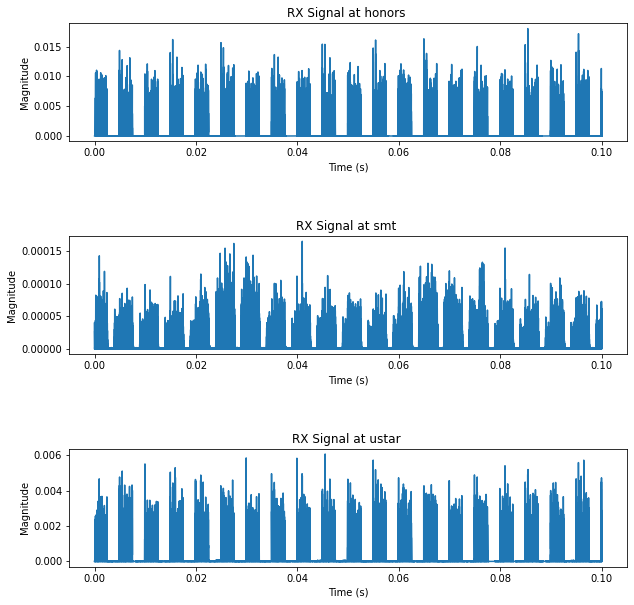

In [ ]:
fig, axs = plt.subplots(fig_row,fig_col, figsize=(10,10))
fig.subplots_adjust(hspace =0.8, wspace=0.3)
f = 0
g = 0
for node in nodes_name:
    raw1 = raw_data[node]
    RAW = complexToMagS(raw1)
    N = len(RAW)
    t = np.linspace(0,(d-d/N),N) # in sec
    if fig_col == 1:
        axs[f].plot(t,RAW)
        axs[f].set_title('RX Signal at %s '% node)
        axs[f].set_xlabel('Time (s)')
        axs[f].set_ylabel('Magnitude')
        f += 1
    else:
        axs[f,g].plot(t,RAW)
        axs[f,g].set_title('RX Signal at %s '% node)
        axs[f,g].set_xlabel('Time (s)')
        axs[f,g].set_ylabel('Magnitude')
        print(f,g)
        g = g + 1
        if g == fig_col:
            f = f+1
            g = 0


Please see from the figure an appropriate period, for example, one packet duration, or the duration between packets.  Set a start time if the signal starts at a time > 0 because typically there is an empty or garbage period of samples at the very start of the recording.

In [ ]:
start_time = 0.00180 # s
duration = 0.000300 # s

Now we plot a zoomed in version of the signals, focused on the time period `start_time` to `start_time + duration`

Starting Sample: 36000; Duration: 5999


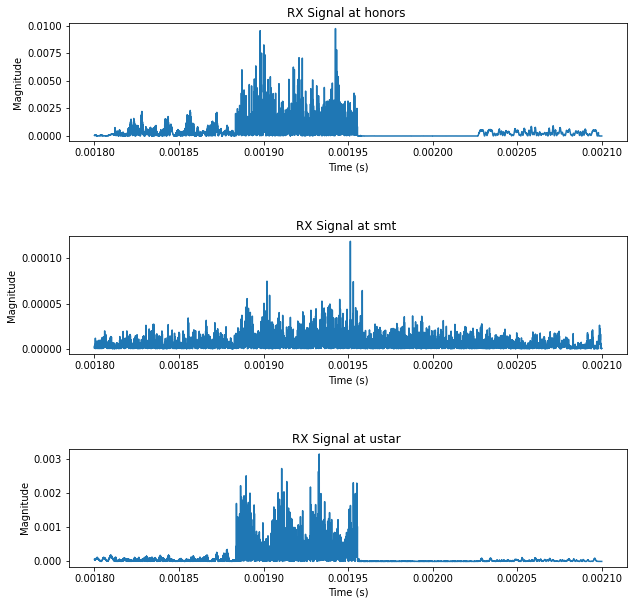

In [ ]:
fig, axs = plt.subplots(fig_row,fig_col, figsize=(10,10))
fig.subplots_adjust(hspace =0.8, wspace=0.3)
f = 0
g = 0
Z = int(np.floor(duration * Fs))  # number of samples to plot
z0 = int(np.floor(start_time * Fs)) # starting sample
print("Starting Sample: " + str(z0) + "; Duration: " + str(Z))
short_signals = dict()
for node in nodes_name:
    raw1 = raw_data[node]
    short_signals[node] = raw1[z0:(Z+z0)]
    t = np.linspace(start_time, start_time + duration - (1.0/Fs), Z) # in sec
    if fig_col == 1:
        axs[f].plot(t,complexToMagS(short_signals[node]))
        axs[f].set_title('RX Signal at %s '% node)
        axs[f].set_xlabel('Time (s)')
        axs[f].set_ylabel('Magnitude')
        f += 1
    else:
        axs[f,g].plot(t,complexToMagS(short_signals[node]))
        axs[f,g].set_title('RX Signal at %s '% node)
        axs[f,g].set_xlabel('Time (s)')
        axs[f,g].set_ylabel('Magnitude')
        print(f,g)
        g += 1
        if g == fig_col:
            f += 1
            g = 0

plt.show()

User caution is required here -- you should visually see that the above plot shows a signal that appears to be from a single source, and the receivers appear to have received it with synchronized clock.  If the clocks are not synched, and the source is sending packets, those packets will not appear at the same time at the different receivers.  If they are synched, then the start times of that received packet at the multiple receivers should be within a microsecond (1e-6 seconds) or two from each other.  Please verify for yourself by plotting the signals.

##  Cross-Correlate and Measure Time Difference of Arrivals

### Cross-correlation
Calculate the cross-correlation between each pair of received signals.  Correlation is typically faster to compute in the frequency domain, but `signal.correlate` says it selects the time or frequency domain depending on which it thinks will be fastest.

We don't need the cross correlation for every possible time difference / lag.  The maximum possible lag between any two receivers is the propagation time between the two.  For POWDER the propagation delay from SMT to Hospital is about 4.3 microseconds, which looks like one of the longest distances we would typically encounter.  Thus I set `max_time_delay_s` to be 4.3 microseconds.  Please change if needed for your setup.

In [ ]:
max_time_delay_s = 4.3e-6 # maximum time delay in seconds
TD = dict()
x_corr = dict()
pairs_name = []
# lags are the time delays which the cross-correlation is calculated for.
lags = signal.correlation_lags(Z, Z, mode='full')
max_sample_delay = int(np.ceil(max_time_delay_s * Fs))
# relevant_lag_t are the "reasonable" time delays which will be plotted.
relevant_lag_indices = np.asarray(abs(lags) < max_sample_delay).nonzero()[0]
relevant_lag_t = lags[relevant_lag_indices] / Fs
# For each pair of nodes
for node1 in nodes_name: 
    for node2 in nodes_name:
        if node2 == node1:  # This break avoids doing each pair twice
            break
        # The pair name has the word " to " in between the two node names.
        pair = node1 + " to " + node2
        pairs_name += [pair]
        # Calculate the correlation. signal.correlate uses the FFT domain if it faster.
        temp = signal.correlate(short_signals[node1], short_signals[node2], mode='full')
        x_corr[pair] = temp[relevant_lag_indices]

print(Z)

5999


### TDOA estimation
This next code segment calculates the TDOA using the maximum of the cross-correlation within the "relevant" time window, for each pair.  Then we plot the cross correlation, marking the estimated TDOA.

**If the cross-correlation plot is very noisy (lots of peaks), then it may be unreliable and should perhaps not be used.**  Typically this happens on all plots for a particular receiver (because it did not receive a strong signal from the same source).  We don't have coded an algorithm to decide if a receiver pair's cross-correlation is too noisy, you have to use your judgement and, if you decide not to use it, add the pair name to `pairs_to_ignore` in code a few blocks down.

TDoA for pair smt to honors: 6e-07 
TDoA for pair ustar to honors: 0.0 
TDoA for pair ustar to smt: -2.6e-06 


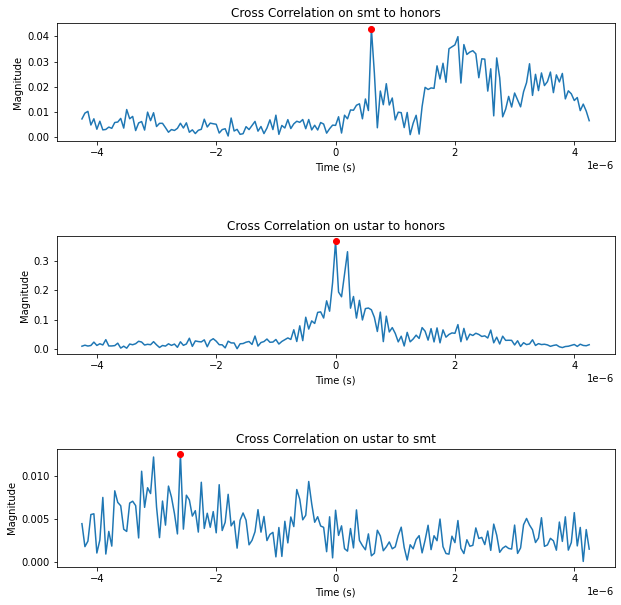

{'smt to honors': 6e-07, 'ustar to honors': 0.0, 'ustar to smt': -2.6e-06}


In [ ]:
fig2, axs2 = plt.subplots(fig_row, fig_col, figsize=(10,10))
fig2.subplots_adjust(hspace =0.8, wspace=0.3)
f = 0
g = 0
for pair in pairs_name: 
    C = np.abs(x_corr[pair])
    mp = np.argmax(C)
    td = relevant_lag_t[mp]  #sec
    print('TDoA for pair %s: %s ' %(pair, td))
    TD[pair] = td
    if fig_col == 1:
        axs2[f].plot(relevant_lag_t, C)
        axs2[f].plot(td, C[mp], 'ro')
        axs2[f].set_title('Cross Correlation on %s' % pair )
        axs2[f].set_xlabel('Time (s)')
        axs2[f].set_ylabel('Magnitude')
        f += 1
    else:
        axs2[f,g].plot(relevant_lag_t, C)
        axs2[f,g].plot(td, C[mp], 'ro')
        axs2[f,g].set_title('Cross Correlation on %s' % pair )
        axs2[f,g].set_xlabel('Time (s)')
        axs2[f,g].set_ylabel('Magnitude')
        g += 1
        if g == fig_col+1:
            f += 1
            g = 0
plt.show()
#fig2.show()
print(TD)

### Note about time differences

We've come up with measured time differences, not the time of arrival itself.  There are some things to note:
- One ns (1e-9 seconds) is about one foot.  (This may be the only reason to like the Imperial system of measurement!) So seeing a TDOA of 1e-6 s means that the difference between a) the distance from source to node1, and b) the distance from source to node2, is about 1000 feet or 300 meters.
- There is at least one redundant TDOA measurement.  Since we're taking the differences in the distances between the source and $N$ receivers, there are $N \choose 2$ differences.  We can take the sum of two differences that include a common node, to be left with the difference that does not include that common node.  So don't be concerned if there's a strange coincidence in your TDOA values.

## Location Estimation

This section uses the TDOA measurements in `TD` to estimate the source location.  Here we do 2D location because we don't have complete z-coordinate 

Each time difference defines a hyperbola where a transmission from a location on that curve would result in the measured TDOA.  

The user should change lat/lon coordinates if needed.  The "heights" values are the building heights above the ground and currently ignore the terrain of the campus deployment. They are also not very accurate, as they are an estimate of the building height in meters.  An update should measure the height of these antennas.

In [ ]:
# All possible receiver/sensor coordinates in UTM 12 T
ant_latlon = {
    "browning": [40.76627,-111.84774],
    "hospital": [40.77105,-111.83712],
    "smt": [40.76740,-111.83118],
    "ustar": [40.76895,-111.84167],
    "bes": [40.76134,-111.84629],
    "honors": [40.76440,-111.83699],
    "fm": [40.75807,-111.85325],
    "moran": [40.77006,-111.83784],
    "ebc": [40.76770,-111.83816],
    "guesthouse": [40.76627,-111.83632],
    "humanities": [40.76486,-111.84319],
    "web": [40.76791,-111.84561],
    "bookstore": [40.76414,-111.84759],
    "sagepoint": [40.76278,-111.83061],
    "law73": [40.76160,-111.85185],
    "garage": [40.76148,-111.84201],
    "madsen": [40.75786,-111.83634],
    "cnode-wasatch-dd-b210": [40.77107659230161, -111.84315777334905],
    "cnode-mario-dd-b210": [40.77281166195038, -111.8409002868012],
    "cnode-moran-dd-b210": [40.77006,-111.83872],
    "cnode-guestho1use-dd-b210": [40.76769,-111.83609],
    "cnode-ustar-dd-b210": [40.76851381022761, -111.8404502186636], 
    "cnode-ebc-dd-b210": [40.76720,-111.83810],
}
# Heights above the ground "plane" in m (estimated)
ant_rel_heights = {
    'hospital': 15,
    'smt': 40, 
    'ustar': 25,
    'bes': 40,
    'honors': 30,
}
# Convert lat lon coords for our nodes into a UTM local coordinate system in meters
ant_utm = dict()
for node in nodes_name:
    # Assume the UTM map locator is identical for all antennas (12T for the SLC area).  
    # Thus drop 3rd, 4th return values. If coords cross UTM maps, this would not be ok.
    x = utm.from_latlon( ant_latlon[node][0], ant_latlon[node][1])
    if node in ant_rel_heights.keys():
        ant_utm[node] = [x[0], x[1], ant_rel_heights[node]]
    else:
        ant_utm[node] = [x[0], x[1], 15]
        print('Using default z-coordinate (height) of 15 m for node: ' + node)

NOTE: If the TDOA is larger than the propagation time between the two receivers, then it's probably wrong. Such an error could be caused by a noisy measured signal, or having more than one signal source.  Check these propagation times here.  If the output indicates `Consider ignoring the measurement on pair` then add that pair string to the `pairs_to_ignore` list.

In [ ]:
for pair in pairs_name: 
    node1, node2 = pairToNodes(pair)
    coord1 = ant_utm[node1]
    coord2 = ant_utm[node2]
    nodedist = dist(coord1, coord2)
    maxTDOA = nodedist/speed_of_light
    print('Max TDOA on ' + pair + ' is ' + str(maxTDOA) + 's')
    print('Measured TDOA on ' + pair + ' is ' + str(TD[pair]) + 's')
    if TD[pair] > maxTDOA:
        print('Consider ignoring the measurement on pair: ' + pair)

Max TDOA on smt to honors is 1.9775863771461872e-06s
Measured TDOA on smt to honors is 6e-07s
Max TDOA on ustar to honors is 2.1389322634208862e-06s
Measured TDOA on ustar to honors is 0.0s
Max TDOA on ustar to smt is 3.008926696028259e-06s
Measured TDOA on ustar to smt is -2.6e-06s


In [ ]:
pairs_to_ignore = ['ustar to smt']  # E.g.: pairs_to_ignore = []; pairs_to_ignore = ['smt to honors']

Generate Coordinates for the possible area.  Please set:
 - `delta_p` to the side length of a pixel in meters.
 - `area_range` to the "margin" on each side of the receiver locations to be included in the area of possible locations.

The algorithm to estimate the location is currently simply to calculate the root mean squared error (RMSE) for each pixel in the grid; and to select as the location estimate the location with the minimum RMSE.  This estimate is typically called the MMSE estimator.

In [ ]:



delta_p = 50 # in meters (side length of each pixel)
further_range = 1000 # extra margin to include on sides of node locations, in meters
deploymentLL, deploymentUR = minimumUtmCoord(ant_utm)
pixelCoords, xVals, yVals = calcGridPixelCoords(deploymentLL, deploymentUR, delta_p, further_range)
Z, i_min = calcRMSE(pixelCoords, ant_utm, TD, pairs_to_ignore)
MMSE_coord = pixelCoords[i_min]
print('Lowest SSE at ' + str(MMSE_coord))

Lowest SSE at [429317.2733436385, 4513290.6862426605, 0]


Plot the RMSE across space, with the node (receiver) locations, and the estimated source location.

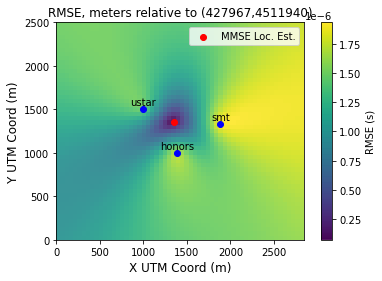

Coordinate [429317.2733436385, 4513290.6862426605, 0] has the minimum RMSE of  74  ns.


In [ ]:
plt.figure()
Z_reshape = np.reshape(Z,(len(yVals),len(xVals)))
Z_flip = np.flipud(Z_reshape)
im = plt.imshow(Z_flip,  cmap=plt.cm.viridis, alpha=.9, extent=[0,xVals[-1] - xVals[0],0,yVals[-1]-yVals[0]])
for node in nodes_name:
    plt.scatter(ant_utm[node][0]- xVals[0], ant_utm[node][1]- yVals[0], color ='b')
    plt.text(ant_utm[node][0]- xVals[0], ant_utm[node][1]- yVals[0]+20, node, horizontalalignment='center',verticalalignment='bottom')
plt.scatter(MMSE_coord[0]- xVals[0], MMSE_coord[1]- yVals[0], color='r', label='MMSE Loc. Est.')
plt.colorbar(im, label='RMSE (s)')
plt.title('RMSE, meters relative to (%d,%d)'%(xVals[0], yVals[0]), fontsize=12)
plt.xlabel('X UTM Coord (m)', fontsize=12)
plt.ylabel('Y UTM Coord (m)', fontsize=12)
plt.legend()
plt.show()
print('Coordinate', MMSE_coord, 'has the minimum RMSE of ', int(Z[i_min]*1.0e9), ' ns.')


In [ ]:
# Convert optimum back to a Lat, Lon coordinate so that you can plot on Maps
print('Estimated coordinate translates to a lat-lon coordinate of:')
est_latlon = utm.to_latlon(MMSE_coord[0], MMSE_coord[1], 12, 'T')
print(est_latlon)
print('https://maps.google.com/?q=%f,%f'%est_latlon)

Estimated coordinate translates to a lat-lon coordinate of:
(40.76754922379067, -111.83750529072286)
https://maps.google.com/?q=40.767549,-111.837505


You can click the above link or copy and past the above (lat,lon) coordinate into Google Maps to see where the estimated source location is.